# NLP Project: Making a prediction of the Programming Language base on README.md
"We don't know, what we don't know"  

By: Cody Watson and Eric Escalante  
May 13, 2019  

In this Jupyter Notebook, we will be scraping data from GitHub repository README files. The goal is to build a model that can predict which programming language a repository is using, given the text of the README file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **requests:** to obtain the HTML from the page  
> **unicodedata:** character encoding  
> **BeautifulSoup:** to parse the HTML and obtain the text/data that we want  
> **nltk:** Natual Language Toolkit that allows us to work with human language data  
> **WordCloud:** creates an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance

In [211]:
import unicodedata
import re
import json

import spacy
from spacy.lang.en import English
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import NLP_acquire
from typing import List, Dict
from pprint import pprint

## Table of contents
1. [Project Planning](#project-planning)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)
1. [Summary](#summary)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. Accurately predict the programming languages based on mutliple programming languages from Github README files
2. Create different WordCloud models showing the most commonly used words with each programming languages
3. Built muliple Classification machine learning models to accurately predict which language the repository is written in
4. Be sure that we are documenting our thoughts throughout the process

### Deliverables
>- A well-documented jupyter notebook that contains your analysis  
>- One or two google slides suitable for a general audience that summarize your findings. Include a well-labelled visualization in your slides.

### Hypotheses
> "C++ programmers are more elitist"

### Thoughts & Questions
> **Thoughts:**  
- Figure out how to apply multiple Classification methods to predict programming language using the repo's readme.md
- Figure out how to apply multiple sentiment analysis methods to the data
- Compare and Contrast different Corpus using TF-IDF
- We want to learn how to set up the Word2Vec for word embedding
- Apply a 'github' image mask to a WordCloud (within the negative/positive space; label each space with different colors)

> **Questions:**  
- What am I? Who are we?
- Does the sentiment in a given languange vier more towards positive or negative?
- How many graphs can we make this weekend??

## Prepare the Environment <a name="preparation"></a>

**Bring in the data from the prepare file**

In [247]:
df = pd.read_json('data.json')

**Going to see what the top portion looks like**

In [248]:
df.head()

,language,readme_contents,repo
0,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",twbs/bootstrap
1,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,facebook/react
2,None,This page is available as an easy-to-read webs...,EbookFoundation/free-programming-books
3,None,"<div align=""center"">\n\t<img width=""500"" heigh...",sindresorhus/awesome
4,None,![Web Developer Roadmap - 2019](https://i.imgu...,kamranahmedse/developer-roadmap


**How many Languages does our CSV have?**

In [250]:
df.language.value_counts()

JavaScript          43
Python              22
Go                   7
Java                 6
C++                  6
CSS                  3
Jupyter Notebook     2
HTML                 2
Swift                2
Ruby                 2
C#                   1
C                    1
Rust                 1
Dart                 1
Assembly             1
TypeScript           1
PHP                  1
Name: language, dtype: int64

**Funtions to clean our readme files**

In [251]:
def basic_clean(text):
    '''
    Function that takes a string and normalized the text using unicodedata
    '''
    text = unicodedata.normalize('NFKD', text.lower())\
        .encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9'\s]", '', text)

def lemmatize(text):
    '''
    Function that lemmatizes the string
    '''
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(text) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    text_lemmatized = ' '.join(lemmas)
    return re.sub(r"\s*(-PRON-|\'s|\')", '', text_lemmatized)

def remove_stopwords(text):
    '''
    Function to remove stopwords from the string
    '''
    tokenizer = ToktokTokenizer()
    stopword_list = stopwords.words('english')
    stopword_list.remove('no')
    stopword_list.remove('not')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopword_list]
    return ' '.join(filtered_tokens)

def clean_readme(string):
    '''
    Function that pipes the funtions together
    '''
    return remove_stopwords(lemmatize(basic_clean(string)))

**Apply our funcitons**

In [252]:
df['readme_clean'] = df.readme_contents.apply(clean_readme)

**Thoughts:**
>- We no longer need the original readme contents, going to dump them
>- We need to now group by the language
>- We are going to start using WordCloud to visually see the frequencies of each word

In [253]:
df.drop(columns='readme_contents', inplace=True)

In [254]:
df.head()

,language,repo,readme_clean
0,JavaScript,twbs/bootstrap,p aligncenter hrefhttpsgetbootstrapcom img src...
1,JavaScript,facebook/react,reacthttpsreactjsorg middot github licensehttp...
2,None,EbookFoundation/free-programming-books,page available easytoread website httpsebookfo...
3,None,sindresorhus/awesome,div aligncenter &#9; img width500 height350 sr...
4,None,kamranahmedse/developer-roadmap,web developer roadmap 2019httpsiimgurcoms5ccv9...


## Exploration  <a name="exploration"></a>

**Thoughts:**
>- Look at Top\Bottom 10 words in each readme grouped by programming language
>- Sentiment Analysis on each languange
>- Figure out how to apply latent Dirichlet allocation
>- Learn how to set up Word2Vec

In [255]:
def get_frequency(df, language):
    '''
    Function that creates a dataframe with words in the repo and their counts
    '''
    language_dict = {}
    temp_df = df[df['language'] == str(language)]
  
    for i, row in temp_df.iterrows():
        row_text = str(row['readme_clean'])
        row_text_words = row_text.split(' ')
    
    for word in row_text_words:
        if word in language_dict:
            language_dict[word] += 1
        else:
            language_dict[word] = 1
        
    return pd.DataFrame.from_records(language_dict, index=[0]).T

**Grab any language and find the frequency**

In [256]:
### Frequencies of words on Java Readme's
js_frequency = get_frequency(df, 'JavaScript')

### Frequencies of words on Python Readme's
python_frequency = get_frequency(df, 'Python')

### Frequencies of words on Go Readme's
go_frequency = get_frequency(df, 'Go')

**What are the 20 most common words on the Java Readme's?**

**Graphs** _(todo)_
>
- Stacked Bargraph
- WordCloud (done)
- anything extra we see

In [261]:
top_20_js_words = js_frequency.sort_values([0], ascending=False).head(20)
top_20_js_words.reset_index(inplace=True)
top_20_js_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_py_words = python_frequency.sort_values([0], ascending=False).head(20)
top_20_py_words.reset_index(inplace=True)
top_20_py_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_go_words = go_frequency.sort_values([0], ascending=False).head(20)
top_20_go_words.reset_index(inplace=True)
top_20_go_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

### JavaScript Word Frequency Visuals

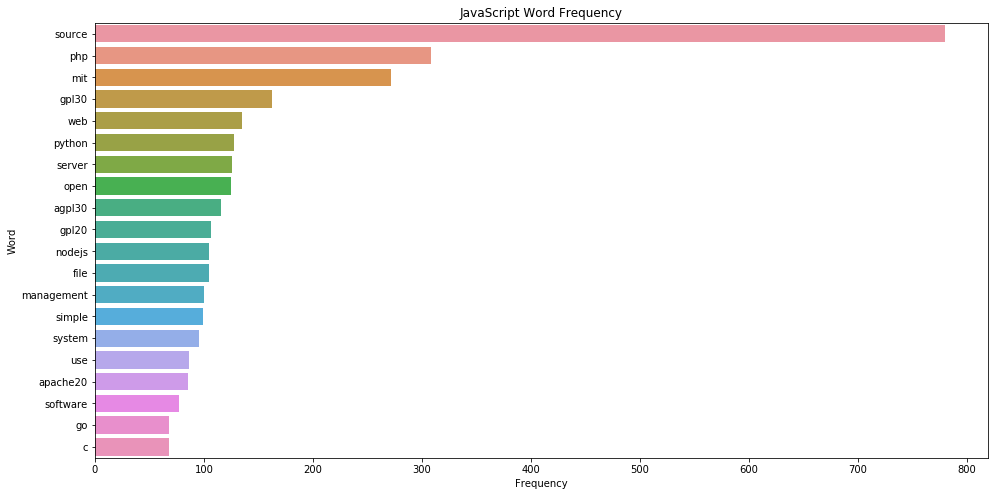

In [283]:
import seaborn as sns

plt.figure(figsize=(16,8))
sns.barplot(top_20_js_words.freq, top_20_js_words.words)
plt.title('JavaScript Word Frequency')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

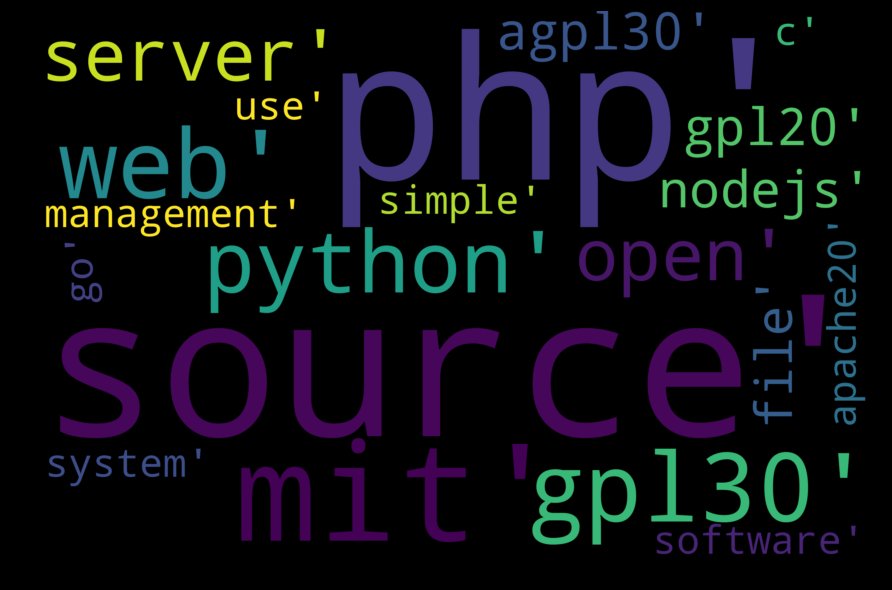

In [267]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_js_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Python Word Frequency Visuals

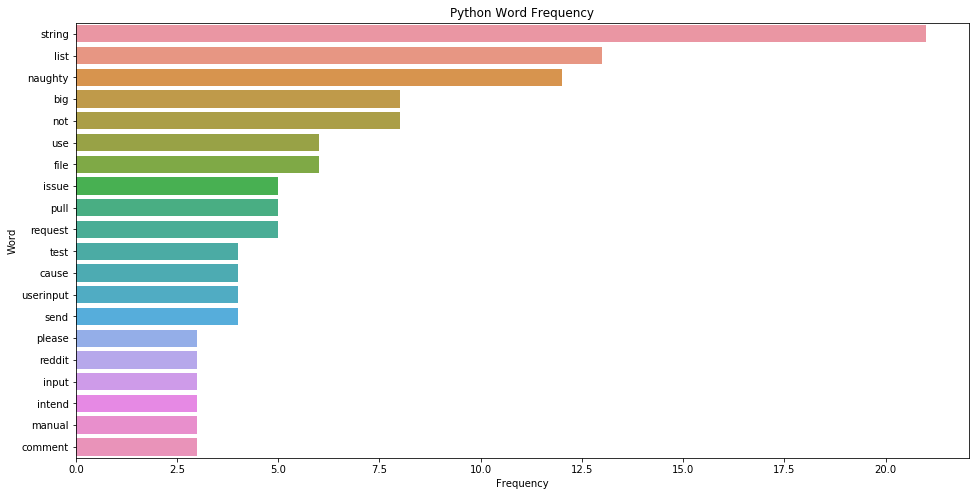

In [281]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_py_words.freq, top_20_py_words.words)
plt.title('Python Word Frequency')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

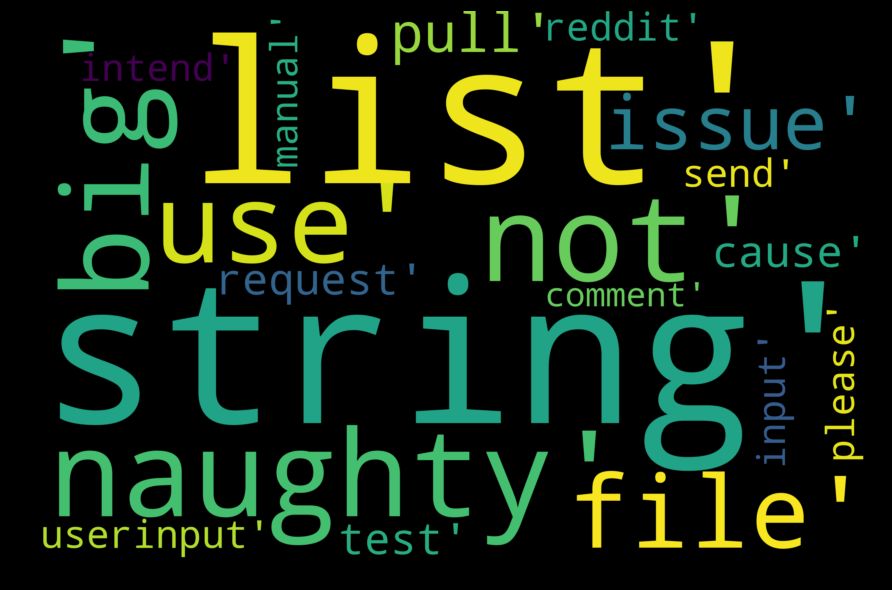

In [268]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_py_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Go programming language Word Frequency Visuals

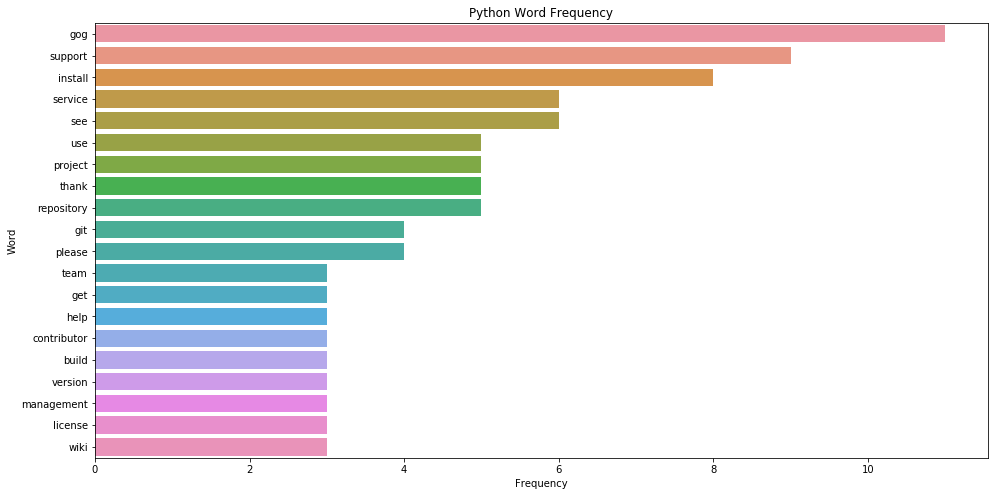

In [284]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_go_words.freq, top_20_go_words.words)
plt.title('Python Word Frequency')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

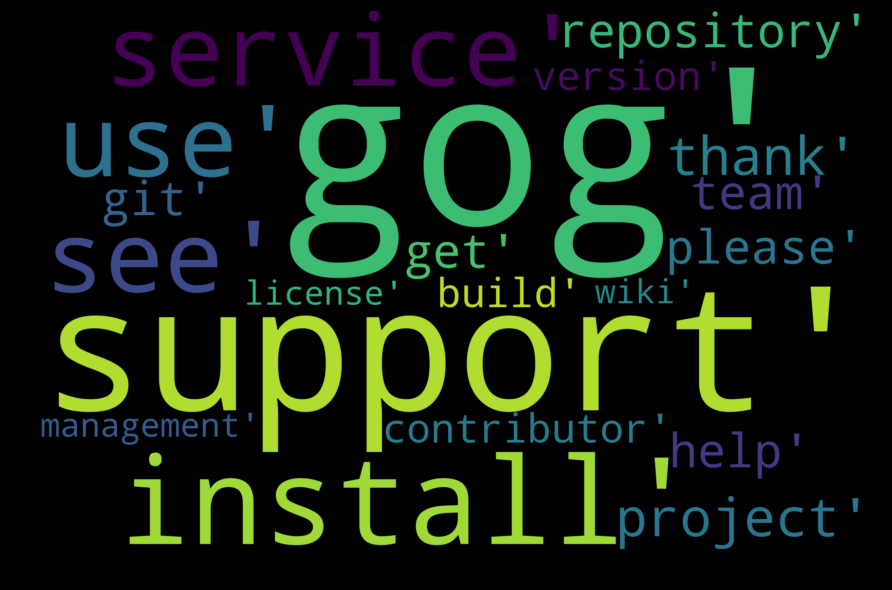

In [269]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_go_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Questions to Answer
- What are the most common words in READMEs?  
- What does the distribution of IDFs look like for the most common words?  
- Does the length of the README vary by language?  
- Do different languages use a different number of unique words?

## Modeling <a name="modeling"></a>

**Bring in multiple classification models**
> _todo_

### Feature Extraction: TF-IDF

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Feature Extraction: Bag of Words

In [226]:
from sklearn.feature_extraction.text import CountVectorizer

features = vectorizer.fit_transform(df.readme_clean)  
features = features.todense()

print(features[:10])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


**List of unique words**

In [228]:
feature_names = vectorizer.get_feature_names()
print(feature_names[:10])

['00', '000000', '0001', '00042', '001', '002', '002099609375ms', '002523', '0033ff', '004200']


**Create a Dataframe with the new features**

In [229]:
df = pd.DataFrame(data=features,
                  columns=feature_names)
df.head()

,00,000000,0001,00042,001,002,002099609375ms,002523,0033ff,004200,...,zulip,zuliphttpszuliporg,zurb,zwischen,zxcvbn,zxf,zxingnet,zydishttpszydisre,zynga,zyszyshttpsgithubcomzyszys
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split
> _todo_

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

### Summarize Conclusions <a name="summary"></a>
> _todo_

### Find different ways to improve model:
> _todo_